In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Color Features (HSV) (first 10): [1.1300e+02 0.0000e+00 9.0000e+00 1.8000e+01 4.0000e+00 4.4000e+01
 6.7000e+01 2.4000e+01 1.3200e+02 1.8700e+02 3.7200e+02 9.4800e+02
 1.8270e+03 5.2030e+03 6.6420e+03 1.0559e+04 6.7610e+03 1.9870e+03
 6.7400e+02 5.4100e+02 3.2400e+02 3.4100e+02 2.4600e+02 1.2500e+02
 1.1600e+02 9.7000e+01 9.6000e+01 1.4000e+01 1.7000e+01 3.3000e+01]
Texture Features (first 10): [0.03497314 0.03915405 0.03337097 0.06678772 0.09538269 0.0844574
 0.04986572 0.04798889 0.46711731 0.0809021 ]
Shape Features (using GrabCut): [39942.5, 783.8549013137817]


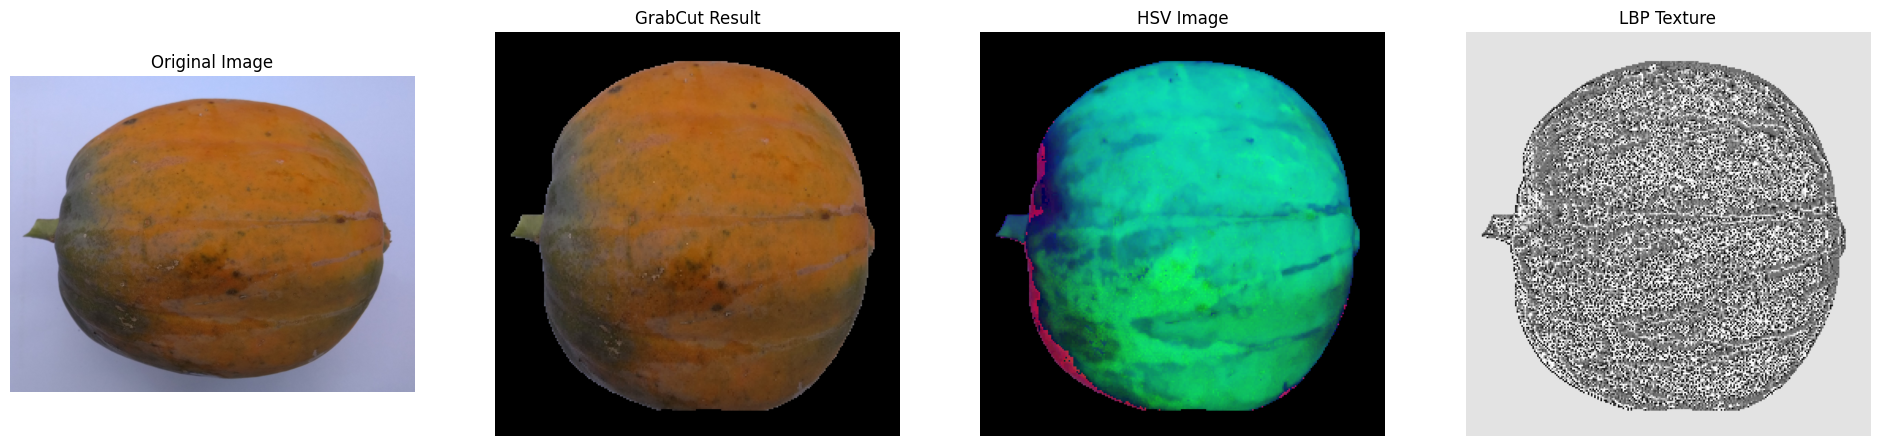

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Load image
image_path = '/content/drive/MyDrive/datasetv2/matang/pepaya (80).jpg'  # Path gambar yang di-upload
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize image for consistent feature extraction
image_resized = cv2.resize(image_rgb, (256, 256))

# Initialize mask
mask = np.zeros(image_resized.shape[:2], np.uint8)

# Define initial rectangle for GrabCut
rect = (10, 10, 230, 230)

# Initialize the background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Apply GrabCut algorithm
cv2.grabCut(image_resized, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

# Modify the mask
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
image_grabcut = image_resized * mask2[:, :, np.newaxis]

# Convert GrabCut result to HSV
hsv_image = cv2.cvtColor(image_grabcut, cv2.COLOR_RGB2HSV)

# Function to extract color histogram in HSV
def extract_color_histogram_hsv(image, mask):
    hist_h = cv2.calcHist([image], [0], mask, [256], [0, 256])
    hist_s = cv2.calcHist([image], [1], mask, [256], [0, 256])
    hist_v = cv2.calcHist([image], [2], mask, [256], [0, 256])
    hist_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    return hist_features

# Function to extract texture features using LBP from HSV image
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return lbp, hist

# Function to extract shape features from the GrabCut result
def extract_shape_features_from_grabcut(image, mask):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(mask_gray, (5, 5), 0)
    contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        return [area, perimeter]
    else:
        return [0, 0]

# Extract features
color_features_hsv = extract_color_histogram_hsv(hsv_image, mask2)
lbp, texture_features = extract_texture_features(hsv_image)
shape_features = extract_shape_features_from_grabcut(image_resized, image_grabcut)

# Combine all features into a single feature vector
features = list(color_features_hsv) + list(texture_features) + shape_features

# Display results
print("Color Features (HSV) (first 10):", color_features_hsv[:30])
print("Texture Features (first 10):", texture_features[:10])
print("Shape Features (using GrabCut):", shape_features)

# Plot original image, GrabCut result, HSV segmented image, and LBP texture visualization
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(image_grabcut)
plt.title("GrabCut Result")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(hsv_image)
plt.title("HSV Image")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(lbp, cmap='gray')
plt.title("LBP Texture")
plt.axis("off")

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Path to dataset
dataset_path = '/content/drive/MyDrive/datasetv2/'

# Function to load dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized = cv2.resize(image_rgb, (256, 256))
                images.append(image_resized)
                labels.append(class_dir)
    return np.array(images), np.array(labels)

# Load the dataset
images, labels = load_dataset(dataset_path)


In [ ]:
# Function to extract color histogram in HSV
def extract_color_histogram_hsv(image, mask):
    hist_h = cv2.calcHist([image], [0], mask, [256], [0, 256])
    hist_s = cv2.calcHist([image], [1], mask, [256], [0, 256])
    hist_v = cv2.calcHist([image], [2], mask, [256], [0, 256])
    hist_features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    return hist_features

# Function to extract texture features using LBP from HSV image
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return lbp, hist

# Function to extract shape features from the GrabCut result
def extract_shape_features_from_grabcut(image, mask):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(mask_gray, (5, 5), 0)
    contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        return [area, perimeter]
    else:
        return [0, 0]

# Initialize mask
def initialize_mask(image_shape):
    return np.zeros(image_shape[:2], np.uint8)

# Define initial rectangle for GrabCut
rect = (10, 10, 230, 230)

# Extract features
def extract_features(images):
    color_features_list = []
    texture_features_list = []
    shape_features_list = []
    for image in images:
        mask = initialize_mask(image.shape)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        image_grabcut = image * mask2[:, :, np.newaxis]
        hsv_image = cv2.cvtColor(image_grabcut, cv2.COLOR_RGB2HSV)

        color_features_hsv = extract_color_histogram_hsv(hsv_image, mask2)
        _, texture_features = extract_texture_features(hsv_image)
        shape_features = extract_shape_features_from_grabcut(image, image_grabcut)

        color_features_list.append(color_features_hsv)
        texture_features_list.append(texture_features)
        shape_features_list.append(shape_features)

    return np.array(color_features_list), np.array(texture_features_list), np.array(shape_features_list)

# Extract features from images
color_features, texture_features, shape_features = extract_features(images)

# Combine all features into a single feature matrix
features = np.hstack([color_features, texture_features, shape_features])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming `features` and `labels` are already defined
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Normalize the features
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [ ]:
# Menampilkan label yang sudah di-encode
print(f"Original labels: {list(le.classes_)}")
print(f"Encoded labels: {list(le.transform(le.classes_))}")

Original labels: ['matang', 'mentah', 'setengah_matang']
Encoded labels: [0, 1, 2]


In [ ]:
# Check the shape of the datasets after splitting
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (408, 780)
Shape of X_test: (102, 780)
Shape of y_train: (408, 3)
Shape of y_test: (102, 3)


Epoch 1/30
13/13 [==============================] - 1s 32ms/step - loss: 1.0696 - accuracy: 0.5245 - val_loss: 0.9797 - val_accuracy: 0.7157
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 0.9050 - accuracy: 0.6912 - val_loss: 0.6540 - val_accuracy: 0.8039
Epoch 3/30
13/13 [==============================] - 0s 14ms/step - loss: 0.5651 - accuracy: 0.8162 - val_loss: 0.3867 - val_accuracy: 0.8627
Epoch 4/30
13/13 [==============================] - 0s 14ms/step - loss: 0.3720 - accuracy: 0.8603 - val_loss: 0.2838 - val_accuracy: 0.8824
Epoch 5/30
13/13 [==============================] - 0s 13ms/step - loss: 0.2789 - accuracy: 0.8799 - val_loss: 0.1954 - val_accuracy: 0.9020
Epoch 6/30
13/13 [==============================] - 0s 14ms/step - loss: 0.2363 - accuracy: 0.8995 - val_loss: 0.1706 - val_accuracy: 0.9510
Epoch 7/30
13/13 [==============================] - 0s 14ms/step - loss: 0.1890 - accuracy: 0.9289 - val_loss: 0.1785 - val_accuracy: 0.9412
Epoch 8/30
13

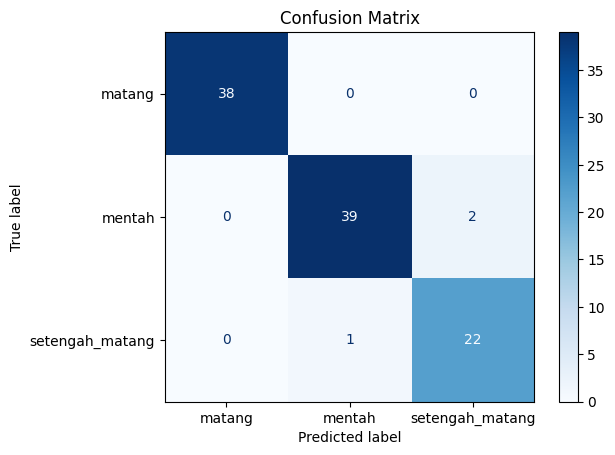

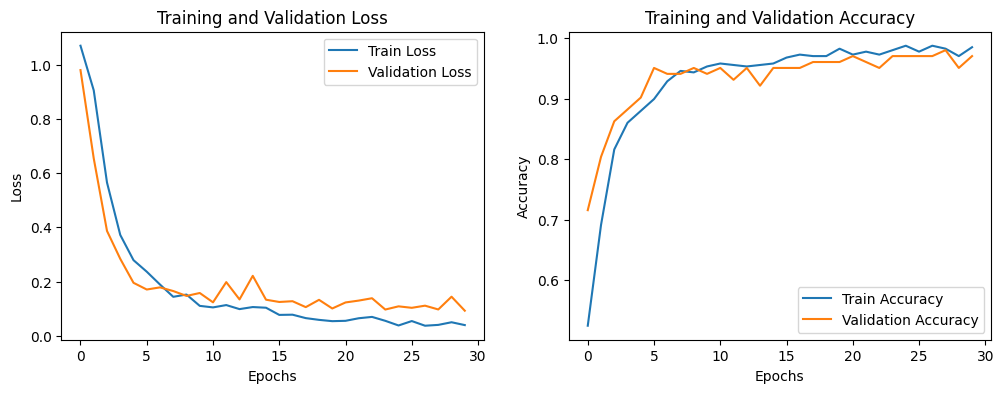

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Generate confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [ ]:
# Save the model
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
